In [9]:
from model import get_backbone, supConClas
from loss import plot_pca, calcualate_inner_outer_distances, contrastiveLoss, calculate_pca_analysis, plot_pca_2
from utils import parse_training_conf

from tqdm import tqdm
import torch
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter


from pytorch_metric_learning import losses

from data import clasDataset, get_transforms, weldingData
from torch.utils.data import DataLoader
import yaml
import os
import json
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import io
from PIL import Image
import torchvision.transforms as transforms



In [10]:
dataset_config_path = '/home/andrii/adient/10multiclass/configs/dataset_config.yaml' 
training_config_path = '/home/andrii/adient/10multiclass/configs/training_conf.yaml'

training_config_file = open(training_config_path, 'r')
training_config_data = yaml.safe_load(training_config_file)

batch_size = training_config_data['batch_size']
device = torch.device(training_config_data['device'])
lr = training_config_data['lr']
num_epochs = training_config_data['num_epochs']
batch_size = training_config_data['batch_size']
n_embeddings = training_config_data['n_embeddings']
pca_save_path = training_config_data['pca_save_path']
log_dir_contrast = training_config_data['log_dir_contrast']  # Replace with your log directory
contrast_save_path = training_config_data['conrast_weights_save_path']
clasifier_save_path = training_config_data['clasifier_head_save_path']
dataset_info_path = training_config_data['dataset_info_path']
save_distro_json_path = training_config_data['store_json_distro']
train_test_data = training_config_data['train_test_split_json']


contrast_writer = SummaryWriter(log_dir_contrast)

to_ten = transforms.ToTensor()

print(f'batch size: {batch_size}')
print(f'learning rate: {lr}')
print(f'num embeddings: {n_embeddings}')
print(f'logs: {log_dir}')
print(f'contrsat weights: {contrast_save_path}')
print(f'clasifier weiights: {clasifier_save_path}')
print(f'json distro path : {save_distro_json_path}')
print(f'train test split json: {train_test_data}')
print(f'pca : {pca_save_path}')



batch size: 5
learning rate: 0.01
num embeddings: 128
logs: /home/andrii/adient/10multiclass/logs
contrsat weights: /home/andrii/adient/10multiclass/weights/projection_layer.pt
clasifier weiights: /home/andrii/adient/10multiclass/weights/clasifier_head.pt
json distro path : /home/andrii/adient/10multiclass/distro.json
train test split json: /home/andrii/adient/welding_data/train_test.json
pca : /home/andrii/adient/10multiclass/pca


In [11]:
wd = weldingData(dataset_config_path = dataset_config_path,
                   training_config_path = training_config_path)
wd.load(train_test_data)

train_trans, test_trans = get_transforms(training_config_path = training_config_path)
train_dataset = clasDataset(wd.train_dict, wd.idx2class, wd.class2idx, train_trans) 
test_dataset = clasDataset(wd.test_dict, wd.idx2class, wd.class2idx, test_trans)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [12]:
t = wd.describe()
with open(dataset_info_path, 'w') as dataset_info:
    dataset_info.write(t)

Num images: 139 
Num train : 96 
Num test  : 43 
JSON path : /home/andrii/adient/welding_data/train_test.json 
 

VOCABULARY 
Healthy : 0 
Porosity : 1 
Oil : 2 
Skip : 3 
BurnThrough : 4 
BlowHole : 5 
Nothces : 6 
UnstableWeld : 7 
WireStick : 8 
Undercut : 9 
LackofFusion : 10 

 
CLASS DISTRIBUTION 
Healthy : 31 
Porosity : 19 
Oil : 9 
Skip : 10 
BurnThrough : 10 
BlowHole : 10 
Nothces : 10 
UnstableWeld : 10 
WireStick : 10 
Undercut : 10 
LackofFusion : 10 



In [13]:
wd.save(save_distro_json_path)

In [14]:
num_classes = len(wd.idx2class)

backbone = get_backbone(size = 'small')
criterion = losses.ArcFaceLoss(num_classes = num_classes, embedding_size = n_embeddings)
model = supConClas(backbone, n_embeddings)
optimizer2 = torch.optim.Adam(list(model.parameters()) + list(criterion.parameters()), lr = lr)

In [15]:
model.train()
model.to(device)
criterion = criterion.to(device)

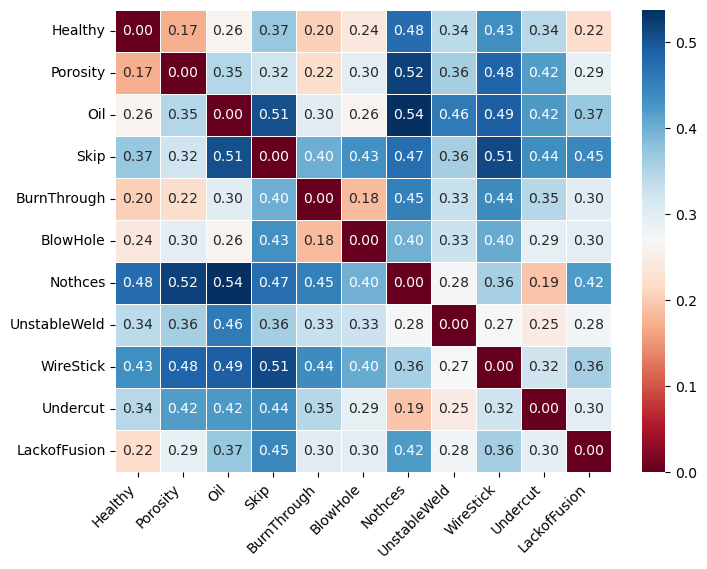

In [17]:
best_val_loss = torch.inf

for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    for idx, (image, label) in enumerate(train_dataloader):
        optimizer2.zero_grad()
        images = image.to(device)
        label  = label.to(device)
        features = model(images)
        loss = criterion(features, label)
        loss.backward()
        training_loss += loss.item() 
        optimizer2.step()
        break
    training_loss/=(idx +1 )
    
    
    val_loss = 0
    model.eval()
    all_features = torch.zeros((1,model.n_embeddings))
    all_labels = torch.tensor([])
    
    for idx, (image, label) in enumerate(test_dataloader):
        images = image.to(device)
        label  = label.to(device)
        with torch.no_grad():
            features = model(images)
        features2 = features.cpu()
        all_features = torch.cat([all_features, features2], dim = 0)
        all_labels = torch.cat([all_labels, label.cpu()])
        loss = criterion(features, label)
        val_loss += loss.item()
    val_loss /= (idx +1 )
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), contrast_save_path)
        
    all_features = all_features[1:,:]   
    inner_d, outer_d = calcualate_inner_outer_distances(all_features.detach(), all_labels.detach())
    if epoch % 4 == 0:
        pca2 = calculate_pca_analysis(all_features.detach(), all_labels.detach())
        plot_pca_2( all_labels.detach(),pca2, test_dataloader.dataset.idx2class, pca_save_path, epoch)
        distance_matrix = np.zeros((num_classes, num_classes))
        outer_d2 = list(outer_d)
        for i in range(num_classes):
            for j in range(i + 1, num_classes):
                distance_matrix[i, j] = outer_d2.pop(0)
                distance_matrix[j, i] = distance_matrix[i, j]

        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        a = sns.heatmap(distance_matrix, cmap='RdBu', annot=True, fmt=".2f", linewidths=.5, ax=ax)
        ax.set_xticklabels(wd.idx2class.values(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(wd.idx2class.values(), fontsize=10, rotation = 0)
        fig = a.get_figure()
        fig.savefig(f"{pca_save_path}/out.png") 

        image = Image.open(f"{pca_save_path}/out.png")
        image_tensor = to_ten(image)
        contrast_writer.add_image(f'Distance_Matrix_Heatmap_{epoch}', image_tensor)

    contrast_writer.add_scalar("Train Loss", training_loss, epoch)
    contrast_writer.add_scalar("Test Loss", val_loss, epoch)
    inner_distances = {f'InnerDistance_c{i}' : inner_d[i] for i in range(len(inner_d))}
    contrast_writer.add_scalars('InnerDistances', inner_distances, global_step=epoch)
    


    break
        
        